## Importation des données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
allData = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")

In [9]:
# On remplace 999 par NaN
allDataModified = allData.replace(-999,np.NaN)
print("nb NaN :", allDataModified.isna().sum().sum())
print("taille totale :", (len(allDataModified.columns) - 4) * len(allDataModified.index))
weights = allData["Weight"].to_numpy().ravel()
# On rend la variable de decision Label en int 0 et 1
allDataModified["Label"] = allDataModified["Label"].apply(lambda x: 1 if x == "s" else 0)
allDataModifiedWithNaN = allDataModified
# On enlève les columns dont on ne va pas se servir
allDataModified = allDataModified.drop(columns = ["KaggleSet","KaggleWeight","Weight"])
#allDataModifiedWithNaN = allDataModified
allDataWithoutNan = allDataModified.dropna(axis=1)
allDataModified = allDataModified.fillna(allDataModified.median())
allDataModified.head()

nb NaN : 5168486
taille totale : 25365378


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,1
1,100001,160.937,68.768,103.235,48.146,2.101,226.193,-0.244,3.473,2.078,...,164.546,1,46.226,0.725,1.158,47.993,-0.011,-0.020,46.226,0
2,100002,112.501,162.172,125.953,35.635,2.101,226.193,-0.244,3.148,9.336,...,260.414,1,44.251,2.053,-2.028,47.993,-0.011,-0.020,44.251,0
3,100003,143.905,81.417,80.943,0.414,2.101,226.193,-0.244,3.310,0.414,...,86.062,0,65.760,0.000,-0.044,47.993,-0.011,-0.020,-0.000,0
4,100004,175.864,16.915,134.805,16.405,2.101,226.193,-0.244,3.891,16.405,...,53.131,0,65.760,0.000,-0.044,47.993,-0.011,-0.020,0.000,0


On découpe en train et test

In [10]:
x = allDataModified.loc[:,allDataModified.columns != 'Label']
x = x.loc[:, x.columns != 'EventId']
y = allDataModified.loc[:,allDataModified.columns == 'Label']
y = y.to_numpy().ravel()
y

array([1, 0, 0, ..., 0, 0, 0])

In [147]:
# Test avec PCA
res = []
for i in range(1,20):
    print(i)
    myPca = PCA(n_components=i)
    myPca.fit(x)
    res.append(sum(myPca.explained_variance_ratio_))

#print(myPca.explained_variance_ratio_) 
#print(sum(myPca.explained_variance_ratio_))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


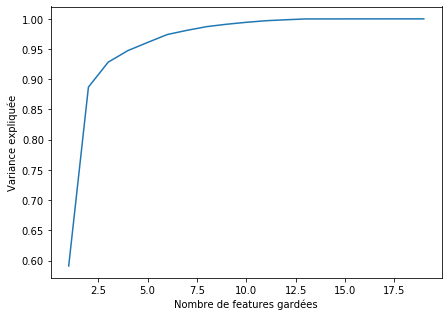

In [148]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(list(range(1,20)),res)
plt.xlabel("Nombre de features gardées")
plt.ylabel("Variance expliquée")
fig.savefig("plots/pcaExplained.jpg")

code de la function AMS

In [11]:
def AMS(y_true,y_pred,weights,br=10):
    confMat = confusion_matrix(y_true,y_pred)
    
    s = 0
    b = 0
    for i in range(len(y_true)):
        # Vrai positif
        if y_pred[i] == 1:
            if y_true[i] == 1:
                s += weights[i]
            else:
                b += weights[i]
    result = np.sqrt(2 * ((s+b+br) * np.log(1 + s / (b + br)) - s ) )
    return result

#amsScorer = make_scorer(AMS, greater_is_better=True)
#AMS([0,0,1,1,1,1,1],
    #[0,1,0,1,0,1,1])

In [12]:
nbSplit = 5
kf = StratifiedKFold(n_splits=nbSplit,shuffle=True,random_state=42)
listIndexFolds = list(kf.split(x,y))
#aa = list(kf.split(x,y))
#print(aa[0][0].shape)
#aa[0][1].shape
#len(aa)
#allDataModified.iloc[aa[0][1]]

In [13]:
def crossValidation(predictor, x, y, nbSplit=5, weights=None):
    
    kf = StratifiedKFold(n_splits=nbSplit,shuffle=True,random_state=42)
    listIndexFolds = list(kf.split(x,y))
    #nbSplit = len(listIndexFolds)
    result = np.zeros((2,nbSplit))
    for foldCount, (indexTrain, indexTest) in enumerate(listIndexFolds):
        print("FoldCount : ",foldCount)
        xTrain = x.iloc[indexTrain,:] 
        xTest = x.iloc[indexTest,:]
        yTrain = y[indexTrain]
        yTest = y[indexTest]
        
        # PCA Stuff
        #myPCA = PCA(n_components=7)
        #myPCA.fit(xTrain)
        #xTrain = myPCA.transform(xTrain)
        #xTest = myPCA.transform(xTest)
        
        predictor.fit(xTrain,yTrain)
        y_pred = predictor.predict(xTest)
        
        # Fonction de cout
        score = accuracy_score(yTest, y_pred)
        result[0,foldCount] = score
        
       
        weightsTest = weights[indexTest]
        amsScore = AMS(yTest, y_pred,weightsTest)
        result[1,foldCount] = amsScore
        
    return result

In [64]:
def crossValidationSeparator(predictor, grosX, listIndexFolds):
    
    #nbSplit = len(listIndexFolds)
    result = np.zeros((2,nbSplit))
    for foldCount, (indexTrain, indexTest) in enumerate(listIndexFolds):
        print("FoldCount : ",foldCount)
        xTrain = grosX.iloc[indexTrain,:] 
        xTest = grosX.iloc[indexTest,:]
        
        
        x0 = xTrain[xTrain.PRI_jet_num == 0]
        x0 = x0.dropna(axis=1,how='all')
        y0 = x0["Label"].to_numpy().ravel()
        #w0 = x0["Weight"].to_numpy().ravel()
        x0 = x0.drop(["EventId","Label","Weight","KaggleSet","KaggleWeight"],axis=1)
        x0 = x0.fillna(x0.median())
        
        
        x1 = xTrain[xTrain.PRI_jet_num == 1]
        x1 = x1.dropna(axis=1,how='all')
        y1 = x1["Label"].to_numpy().ravel()
        #w1 = x1["Weight"].to_numpy().ravel()
        x1 = x1.drop(["EventId","Label","Weight","KaggleSet","KaggleWeight"],axis=1)
        x1 = x1.fillna(x1.median())
        
        
        x23 = xTrain[xTrain.PRI_jet_num >= 2]
        y23 = x23["Label"].to_numpy().ravel()
        #w23 = x23["Weight"].to_numpy().ravel()
        x23 = x23.drop(["EventId","Label","Weight","KaggleSet","KaggleWeight"],axis=1)
        x23 = x23.fillna(x0.median())
        
        
        yTest = grosX["Label"].to_numpy().ravel()
        wTest = grosX["Weight"].to_numpy().ravel()
        
        
        
        # PCA Stuff
        #myPCA = PCA(n_components=7)
        #myPCA.fit(xTrain)
        #xTrain = myPCA.transform(xTrain)
        #xTest = myPCA.transform(xTest)
        
        predictor.fit(x0,x1,x23,y0,y1,y23)
        y_pred = predictor.predict(xTest)
        
        # Fonction de cout
        score = accuracy_score(yTest, y_pred)
        result[0,foldCount] = score
        
       
        #weightsTest = weights[indexTest]
        amsScore = AMS(yTest, y_pred,wTest)
        result[1,foldCount] = amsScore
        
    return result

# Classification

## Baselines

Decision Tree with one node

In [150]:
mySimpleTree = DecisionTreeClassifier(max_depth = 1)
cv_results = crossValidation(mySimpleTree,x,y,listIndexFolds, weights)
print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6753181846808614  +-  0.0011572582589546951
AMS :  0.7353346853511811  +-  0.0045488301957355955


Perceptron

In [151]:
myPerceptron = Perceptron()
cv_results = crossValidation(myPerceptron,x,y,listIndexFolds, weights)
print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6048910785976203  +-  0.0792366976908214
AMS :  0.47558836005820604  +-  0.11472271335131633


Naive Bayes

In [152]:
myBayes = GaussianNB()
cv_results = crossValidation(myBayes,x,y,listIndexFolds, weights)
print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7091359715209687  +-  0.0009307824128041385
AMS :  0.5263344890306334  +-  0.01133812898612802


[Text(167.4, 163.07999999999998, 'X[0] <= 48.993\ngini = 0.45\nsamples = 818238\nvalue = [538678, 279560]'),
 Text(83.7, 54.360000000000014, 'gini = 0.5\nsamples = 426453\nvalue = [208902, 217551]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.266\nsamples = 391785\nvalue = [329776, 62009]')]

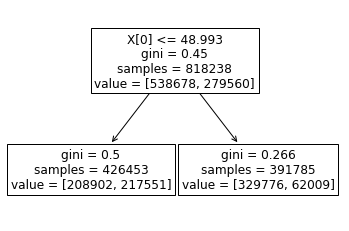

In [126]:
mySimpleTree = DecisionTreeClassifier(max_depth = 1)
mySimpleTree.fit(x,y)
sklearn.tree.plot_tree(mySimpleTree)

## Selection de variables 

## Méthodes d'ensemble avec exploration d'hyper paramètres

Décider des paramètres à explorer pour le random forest

In [133]:
nbArbres = [5,10,50]
profMax = [10,100]

In [144]:
matriceAccMoyenne = np.zeros((len(nbArbres),len(profMax)))
matriceAccVariance = np.zeros((len(nbArbres),len(profMax)))
matriceAmsMoyenne = np.zeros((len(nbArbres),len(profMax)))
matriceAmsVariance = np.zeros((len(nbArbres),len(profMax)))
for countNbArb, nbArb in enumerate(nbArbres):
    for countProf, profondeur in enumerate(profMax):
        print("nb arbre =",nbArb, "\t profondeur=", profondeur)
        myRandomForest = RandomForestClassifier(n_estimators=nbArb, max_depth=profondeur)
        cv_results = crossValidation(myRandomForest,x,y,listIndexFolds,weights)
        matriceAccMoyenne[countNbArb,countProf] = np.mean(cv_results[0,:])
        matriceAccVariance[countNbArb,countProf] = np.std(cv_results[0,:])
        matriceAmsMoyenne[countNbArb,countProf] = np.mean(cv_results[1,:])
        matriceAmsVariance[countNbArb,countProf] = np.std(cv_results[1,:])
        print("moyenne Accuracy :",matriceAccMoyenne[countNbArb,countProf]," +- ",matriceAccVariance[countNbArb,countProf])
        print("moyenne AMS :",matriceAmsMoyenne[countNbArb,countProf]," +- ",matriceAmsVariance[countNbArb,countProf])
print(matriceAccMoyenne)
print(matriceAmsMoyenne)


nb arbre = 5 	 profondeur= 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.8073250121926309  +-  0.0019502553102288588
moyenne AMS : 1.089825940385336  +-  0.013797231472900488
nb arbre = 5 	 profondeur= 100
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.7924858035428921  +-  0.0007557545018184981
moyenne AMS : 0.9503512870838005  +-  0.0046284981924863515
nb arbre = 10 	 profondeur= 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.8102850247167505  +-  0.0010283200304334063
moyenne AMS : 1.1052390599886275  +-  0.008620029294542704
nb arbre = 10 	 profondeur= 100
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.8050322762376592  +-  0.0007714129208567703
moyenne AMS : 1.0549693989549231  +-  0.007043567907641162
nb arbre = 50 	 profondeur= 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
Fold

In [17]:
np.save("matriceMoyenneRandomForest",matriceMoyenne)
np.save("matriceVarianceRandomForest",matriceVariance)

In [138]:
matriceAmsMoyenne

array([[1.04083554, 0.94523893],
       [1.0493256 , 1.06526217],
       [1.07228581, 1.14807336]])

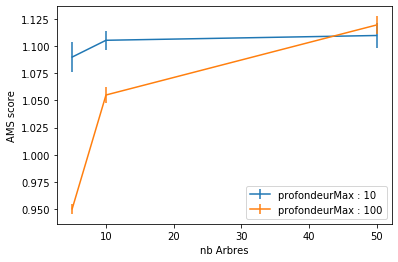

In [145]:
plt.errorbar(nbArbres,matriceAmsMoyenne[:,0],matriceAmsVariance[:,0],label="profondeurMax : "+str(profMax[0]))
plt.errorbar(nbArbres,matriceAmsMoyenne[:,1],matriceAmsVariance[:,1],label="profondeurMax : "+str(profMax[1]))
#plt.errorbar(nbArbres,matriceAmsMoyenne[2,:],matriceAmsVariance[2,:],label="profondeurMax : "+str(profMax[2]))
plt.legend()
plt.xlabel("nb Arbres")
plt.ylabel("AMS score")
plt.savefig("RandomForestArbresFullData.jpg")

AdaBoost

In [163]:
nbEstimators = [1,10,100]

In [130]:
matAccAda = np.zeros((2,len(nbEstimators)))
matAMSAda = np.zeros((2,len(nbEstimators)))
for countNbEstimator, nbEst in enumerate(nbEstimators):
    print("nb estimator =",nbEst)
    myAda = AdaBoostClassifier(n_estimators=nbEst)
    cv_results = crossValidation(myAda,x,y,listIndexFolds,weights)
    matAccAda[0,countNbEstimator] = np.mean(cv_results[0,:])
    matAccAda[1,countNbEstimator] = np.std(cv_results[0,:])
    matAMSAda[0,countNbEstimator] = np.mean(cv_results[1,:])
    matAMSAda[1,countNbEstimator] = np.std(cv_results[1,:])
    print("moyenne Accuracy :",matAccAda[0,countNbEstimator]," +- ",matAccAda[1,countNbEstimator])
    print("moyenne AMS :",matAMSAda[0,countNbEstimator]," +- ",matAMSAda[1,countNbEstimator])
print(matAccAda)
print(matAMSAda)

nb estimator = 1
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.6686648582424661  +-  0.0036119702402740723
moyenne AMS : 0.6719318117005948  +-  0.003932562199921801
nb estimator = 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.7329028972485678  +-  0.001578043907248325
moyenne AMS : 0.7919895991765877  +-  0.0039018190970426404
nb estimator = 100
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.7448615210197482  +-  0.001296758870763722
moyenne AMS : 0.8804928466412703  +-  0.00454290948581362
[[0.66866486 0.7329029  0.74486152]
 [0.00361197 0.00157804 0.00129676]]
[[0.67193181 0.7919896  0.88049285]
 [0.00393256 0.00390182 0.00454291]]


In [154]:
# AdaBoost sans pré traitement
matAccAda = [[0.6681112348432099, 0.7985427234070376, 0.818378026249813],[0.0007297091458786361, 0.0010682124405013793, 0.0003511076476797158]]
matAMSAda = [[0.7646952397593465,1.056955177522457,1.135298497505358],[0.004521009182686826,0.01022466867878882,0.007072179835980235 ]]

In [131]:
np.save("matAccAdaPCA",matAccAda)
np.save("matAMSAdaPCA",matAMSAda)

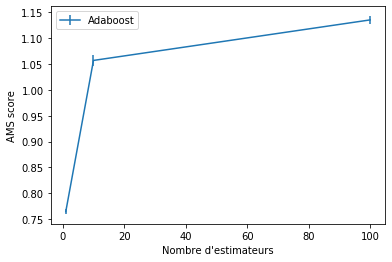

In [164]:
plt.errorbar(nbEstimators,matAMSAda[0],matAMSAda[1],label="Adaboost")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("AMS score")
plt.legend()
plt.savefig("AdaBoostFullData.jpg")

In [160]:
matAMSAda[0]

[0.7646952397593465, 1.056955177522457, 1.135298497505358]

# RECHERCHE D'HYPER PARAM

In [14]:
# Découpe dataset en 2, 
# cross val avec recherche d'hyper param sur le premier, cross val avec ces hypers params sur l'ensemble de test.
# Une fonction qui fait tout ? -> non

# Découpe dataset en deux
kf = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
listIndexFolds = list(kf.split(x,y))
indexTrain, indexTest = listIndexFolds[0]
print(indexTrain.shape, indexTest.shape)
xTrain = x.iloc[indexTrain,:]
yTrain = y[indexTrain]
wTrain = weights[indexTrain]

xTest = x.iloc[indexTest,:]
yTest = y[indexTest]
wTest = weights[indexTest]

#hyperParam1 = [1,10]
#for 





(409119,) (409119,)


In [23]:
# cross val avec recherche d'hyper param sur le premier, cross val avec ces hypers params sur l'ensemble de test.
stumpParam = ["gini","entropy"]
matAccMoyenne = np.zeros((len(stumpParam),1))
matAccVar = np.zeros((len(stumpParam),1))
matAMSMoyenne = np.zeros((len(stumpParam),1))
matAMSVar = np.zeros((len(stumpParam),1))

for countH, param in enumerate(stumpParam):
    
    # Créé le predictor avec les hypersParams
    predictor = DecisionTreeClassifier(max_depth = 1,criterion=param)
    
    # Fit/test en crossVal
    cvRes = crossValidation(predictor, xTrain, yTrain, nbSplit=5, weights=wTrain)
    print("Param : ", param, "\n\t acc : ", np.mean(cvRes[0,:]), "+-", np.std(cvRes[0,:]), "\n\t AMS : ", np.mean(cvRes[1,:]), "+-", np.std(cvRes[1,:]))
    matAccMoyenne[countH] = np.mean(cvRes[0,:])
    matAMSMoyenne[countH] = np.mean(cvRes[1,:])
    matAccVar[countH] = np.std(cvRes[0,:])
    matAMSVar[countH] = np.std(cvRes[1,:])
    
    
# Selectionner les meilleurs hyper paramètres

    
    


FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Param :  gini 
	 acc :  0.6710247997156467 +- 0.007008345056756048 
	 AMS :  0.5426113024436301 +- 0.008579549270355862
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Param :  entropy 
	 acc :  0.6591260714110183 +- 0.0015745286760444788 
	 AMS :  0.10739523845690062 +- 0.21479047691380124


In [27]:
# cross val avec recherche d'hyper param sur le premier, cross val avec ces hypers params sur l'ensemble de test.
percepParam1 = ["l1","l2","elasticnet"]
percepParam2 = [0.001,0.01,0.1]
lenParam1 = len(percepParam1)
lenParam2 = len(percepParam2)
matAccMoyenne = np.zeros((lenParam1,lenParam2))
matAccVar = np.zeros((lenParam1,lenParam2))
matAMSMoyenne = np.zeros((lenParam1,lenParam2))
matAMSVar = np.zeros((lenParam1,lenParam2))

for countH, param in enumerate(percepParam1):
    for countH2, param2 in enumerate(percepParam2):
    
        # Créé le predictor avec les hypersParams
        predictor = Perceptron(penalty = param, alpha=param2)

        # Fit/test en crossVal
        cvRes = crossValidation(predictor, xTrain, yTrain, nbSplit=5, weights=wTrain)
        print("Params : ", param,",",param2, "\n\t acc : ", np.mean(cvRes[0,:]), "+-", np.std(cvRes[0,:]), "\n\t AMS : ", np.mean(cvRes[1,:]), "+-", np.std(cvRes[1,:]))
        matAccMoyenne[countH,countH2] = np.mean(cvRes[0,:])
        matAMSMoyenne[countH,countH2] = np.mean(cvRes[1,:])
        matAccVar[countH,countH2] = np.std(cvRes[0,:])
        matAMSVar[countH,countH2] = np.std(cvRes[1,:])
         
        
        

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  l1 , 0.001 
	 acc :  0.6382324502808654 +- 0.09587251503065425 
	 AMS :  0.4402434359665809 +- 0.09243956965008805
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  l1 , 0.01 
	 acc :  0.6658063858782121 +- 0.09186960516314294 
	 AMS :  0.47239130198699114 +- 0.09017311576105472
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  l1 , 0.1 
	 acc :  0.5615386205621183 +- 0.15413267602120134 
	 AMS :  0.4214575950484316 +- 0.07766473689326844
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  l2 , 0.001 
	 acc :  0.564000056021991 +- 0.14089854172674268 
	 AMS :  0.36166445955123205 +- 0.07969524929392541
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  l2 , 0.01 
	 acc :  0.5591041454464237 +- 0.15298695025653888 
	 AMS :  0.28047396376316946 +- 0.18132402829975808
Fo

In [15]:
# cross val avec recherche d'hyper param sur le premier, cross val avec ces hypers params sur l'ensemble de test.
RandomFParam1 = [1,5,10,50] # nbArbres
RandomFParam2 = [1,10,50,100] # MaxProfondeur
lenParam1 = len(RandomFParam1)
lenParam2 = len(RandomFParam2)
matAccMoyenne = np.zeros((lenParam1,lenParam2))
matAccVar = np.zeros((lenParam1,lenParam2))
matAMSMoyenne = np.zeros((lenParam1,lenParam2))
matAMSVar = np.zeros((lenParam1,lenParam2))

for countH, param in enumerate(RandomFParam1):
    for countH2, param2 in enumerate(RandomFParam2):
    
        # Créé le predictor avec les hypersParams
        predictor = RandomForestClassifier(n_estimators=param, max_depth=param2,n_jobs=-1)

        # Fit/test en crossVal
        cvRes = crossValidation(predictor, xTrain, yTrain, nbSplit=5, weights=wTrain)
        print("Params : ", param,",",param2, "\n\t acc : ", np.mean(cvRes[0,:]), "+-", np.std(cvRes[0,:]), "\n\t AMS : ", np.mean(cvRes[1,:]), "+-", np.std(cvRes[1,:]))
        matAccMoyenne[countH,countH2] = np.mean(cvRes[0,:])
        matAMSMoyenne[countH,countH2] = np.mean(cvRes[1,:])
        matAccVar[countH,countH2] = np.std(cvRes[0,:])
        matAMSVar[countH,countH2] = np.std(cvRes[1,:])
         

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  1 , 1 
	 acc :  0.6649165485326451 +- 0.008489991441411406 
	 AMS :  0.18067600952201074 +- 0.22791401605418965
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  1 , 10 
	 acc :  0.8076281076701084 +- 0.003445305248679726 
	 AMS :  0.780484933931992 +- 0.022298551439025812
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  1 , 50 
	 acc :  0.7586716817011142 +- 0.0013436064706169415 
	 AMS :  0.5600794148483226 +- 0.0034584112402782988
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  1 , 100 
	 acc :  0.75574098884889 +- 0.002314499338204935 
	 AMS :  0.5517934035294905 +- 0.004181738291683006
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  5 , 1 
	 acc :  0.6905961023690352 +- 0.022465764402285555 
	 AMS :  0.22955947647657418 +- 0.16472081410649209
FoldCount : 

In [35]:
#np.save("matAccMoyenneRF",matAccMoyenne)
#np.save("matAccVarRF",matAccVar)
#np.save("matAMSMoyenneRF",matAMSMoyenne)
#np.save("matMSVarRF",matAMSVar)
matAccMoyenne = np.load("matAccMoyenneRF.npy")
matAccVar = np.load("matAccVarRF.npy")
matAMSMoyenne = np.load("matAMSMoyenneRF.npy")
matAMSVar = np.load("matMSVarRF.npy")


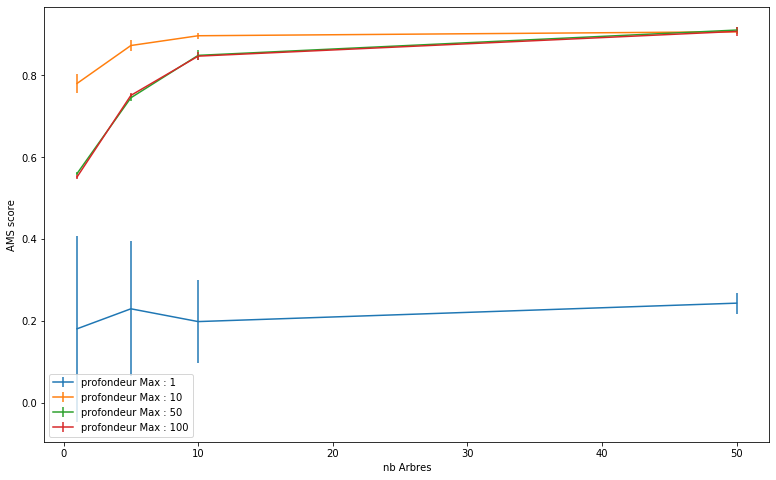

In [44]:
plt.figure(figsize=(13,8))
for i in range(len(RandomFParam1)):
    plt.errorbar(RandomFParam1,matAMSMoyenne[:,i],matAMSVar[:,i],label="profondeur Max : "+str(RandomFParam2[i]))
#plt.errorbar(RandomFParam2,matAMSMoyenne[:,0],matAMSVar[:,0],label="profondeur Max : "+str(RandomFParam2[0]))
#plt.errorbar(RandomFParam2,matAMSMoyenne[:,0],matAMSVar[:,0],label="profondeur Max : "+str(RandomFParam2[0]))
#plt.errorbar(RandomFParam2,matAMSMoyenne[:,0],matAMSVar[:,0],label="profondeur Max : "+str(RandomFParam2[0]))
#plt.errorbar(nbArbres,matriceAmsMoyenne[2,:],matriceAmsVariance[2,:],label="profondeurMax : "+str(profMax[2]))
plt.legend()
plt.xlabel("nb Arbres")
plt.ylabel("AMS score")
plt.savefig("RandomForestArbresFullData.jpg")

In [22]:
# cross val avec recherche d'hyper param sur le premier, cross val avec ces hypers params sur l'ensemble de test.
AdaboostParam1 = [1,10,50,100] # Max profondeur
lenParam1 = len(AdaboostParam1)
matAccMoyenne = np.zeros(lenParam1)
matAccVar = np.zeros(lenParam1)
matAMSMoyenne = np.zeros(lenParam1)
matAMSVar = np.zeros(lenParam1)

for countH, param in enumerate(AdaboostParam1):
    
    # Créé le predictor avec les hypersParams
    predictor = AdaBoostClassifier(n_estimators=param, n_jobs=-1)

    # Fit/test en crossVal
    cvRes = crossValidation(predictor, xTrain, yTrain, nbSplit=5, weights=wTrain)
    print("Params : ", param, "\n\t acc : ", np.mean(cvRes[0,:]), "+-", np.std(cvRes[0,:]), "\n\t AMS : ", np.mean(cvRes[1,:]), "+-", np.std(cvRes[1,:]))
    matAccMoyenne[countH] = np.mean(cvRes[0,:])
    matAMSMoyenne[countH] = np.mean(cvRes[1,:])
    matAccVar[countH] = np.std(cvRes[0,:])
    matAMSVar[countH] = np.std(cvRes[1,:])


FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  1 
	 acc :  0.6710247997156467 +- 0.007008345056756048 
	 AMS :  0.5426113024436301 +- 0.008579549270355862
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  10 
	 acc :  0.7990462454688732 +- 0.0012020656568903702 
	 AMS :  0.7486631934576161 +- 0.015127608755954817
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  50 
	 acc :  0.8139416639043219 +- 0.0005332302401138275 
	 AMS :  0.7898007145692381 +- 0.011017271026849886
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
Params :  100 
	 acc :  0.8183706938160837 +- 0.0006845407421918415 
	 AMS :  0.7990688467287719 +- 0.009315546344573128


In [45]:
#np.save("matAccMoyenneAda",matAccMoyenne)
#np.save("matAccVarAda",matAccVar)
#np.save("matAMSMoyenneAda",matAMSMoyenne)
#np.save("matMSVarAda",matAMSVar)
matAccMoyenne = np.load("matAccMoyenneAda.npy")
matAccVar = np.load("matAccVarAda.npy")
matAMSMoyenne = np.load("matAMSMoyenneAda.npy")
matAMSVar = np.load("matMSVarAda.npy")

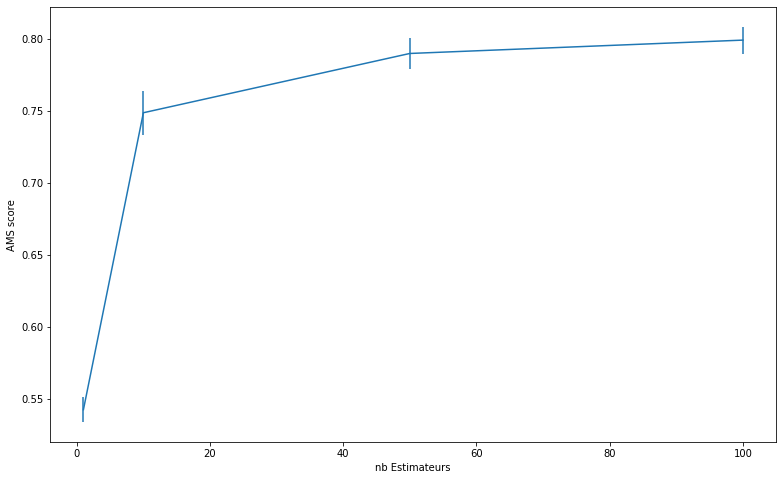

In [46]:
plt.figure(figsize=(13,8))
plt.errorbar(AdaboostParam1,matAMSMoyenne,matAMSVar)
#plt.legend()
plt.xlabel("nb Estimateurs")
plt.ylabel("AMS score")
plt.savefig("AdaFullData.jpg")

## Utilisation de l'ensemble de test pour avoir les résultats finaux 

In [28]:
# Result : 1 ligne par modèle, 4 colonnes (moyenne, variance pour AMS, Accuracy)
# Gaussian, Percep, Stump, Decision Tree (prof 10), Random Forest, Adaboost
result = np.zeros((6,4))

# On créé tous nos modèles
gauss = GaussianNB()
percep = Perceptron(penalty = 'l1', alpha=0.01,n_jobs=-1)
stump = DecisionTreeClassifier(max_depth = 1,criterion='gini')
decisionTree = DecisionTreeClassifier(criterion='gini')
rf = RandomForestClassifier(n_estimators=50, max_depth=10,n_jobs=-1)
ada = AdaBoostClassifier(n_estimators=100)

listModeles = [gauss, percep, stump, decisionTree, rf, ada]

for i, mod in enumerate(listModeles):
    cvRes = crossValidation(mod, xTest, yTest, nbSplit=5, weights=wTest)
    result[i,0] = np.mean(cvRes[0,:])
    result[i,1] = np.std(cvRes[0,:])
    result[i,2] = np.mean(cvRes[1,:])
    result[i,3] = np.std(cvRes[1,:])
    print(i, result[i])

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
0 [0.68960132 0.00149579 0.31340757 0.00439595]
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
1 [0.62039919 0.09160261 0.4092793  0.13923776]
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
2 [0.67008133 0.00292495 0.54376573 0.00793707]
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
3 [0.76564765 0.00119737 0.57277124 0.00826115]
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
4 [0.83213442 0.00106074 0.90610829 0.01538632]
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
5 [0.81816782 0.00123863 0.7990272  0.01028036]


In [30]:
df = pd.DataFrame(data = result, index = ["NaiveBayes","Perceptron", "Stump", "Decision Tree", "Random Forest", "AdaBoost"], columns=["Moyenne Accuracy","Variance Accuracy","Moyenne AMS","Variance AMS"]) 

In [33]:
df.to_csv("csv/testResult.csv")

# TP3 - SUB MANIFOLD

In [ ]:
monTsne = TSNE(n_components=2)
xReduit = monTsne.fit_transform(x)
plt.plot(xReduit) 

In [ ]:
plt.scatter(xReduit[:,0], xReduit[:,1])

# Decoupage en 3 Modèles

In [46]:
x0 = allDataModifiedWithNaN[allDataModifiedWithNaN.PRI_jet_num == 0]
x0 = x0.dropna(axis=1,how='all')
y0 = x0["Label"].to_numpy().ravel()
w0 = x0["Weight"].to_numpy().ravel()
x0 = x0.drop(["EventId","Label","Weight","KaggleSet","KaggleWeight"],axis=1)
x0 = x0.fillna(x0.median())
x0.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
3,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-0.0
4,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,0.0
8,105.594,50.559,100.989,4.288,2.904,4.288,65.333,0.675,-1.366,39.008,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0,0.0
10,111.476,86.240,79.692,27.201,2.338,27.201,81.734,1.750,-1.412,29.718,-0.866,2.878,52.016,0.126,-1.288,51.276,0.688,250.178,0,0.0
13,82.488,31.663,64.128,8.232,2.823,8.232,58.649,1.303,-1.414,25.470,-0.654,-2.990,33.179,-1.665,-0.354,12.439,1.433,163.420,0,0.0


In [47]:
x1 = allDataModifiedWithNaN[allDataModifiedWithNaN.PRI_jet_num == 1]
x1 = x1.dropna(axis=1,how='all')
y1 = x1["Label"].to_numpy().ravel()
w1 = x1["Weight"].to_numpy().ravel()
x1 = x1.drop(["EventId","Label","Weight","KaggleSet","KaggleWeight"],axis=1)
x1 = x1.fillna(x1.median())
x1.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,...,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_all_pt
1,160.937,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,42.014,...,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,46.226
2,112.577,162.172,125.953,35.635,3.148,9.336,197.814,3.776,1.414,32.154,...,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,44.251
7,154.916,10.418,94.714,29.169,2.897,1.526,138.178,0.365,-1.305,78.800,...,0.506,-1.347,22.275,-1.761,187.299,1,30.638,-0.715,-1.724,30.638
9,128.053,88.941,69.272,193.392,1.609,28.859,255.123,0.599,0.538,54.646,...,-0.317,-0.636,132.678,0.845,294.741,1,167.735,-2.767,-2.514,167.735
12,145.297,64.234,103.565,106.999,2.183,24.660,192.245,0.576,0.689,62.890,...,0.722,-0.035,43.910,-1.907,232.362,1,93.117,-0.970,1.943,93.117


In [48]:
x23 = allDataModifiedWithNaN[allDataModifiedWithNaN.PRI_jet_num >= 2]
y23 = x23["Label"].to_numpy().ravel()
w23 = x23["Weight"].to_numpy().ravel()
x23 = x23.drop(["EventId","Label","Weight","KaggleSet","KaggleWeight"],axis=1)
x23 = x23.fillna(x0.median())
x23.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
5,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,278.876,...,2.237,282.849,3,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
6,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,305.967,...,-1.443,294.074,2,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
11,114.744,10.286,75.712,30.816,2.563,252.599,-1.401,2.888,36.745,239.804,...,2.148,290.547,3,76.773,-0.790,0.303,56.876,1.773,-2.079,165.640
23,141.481,0.736,111.581,174.075,1.955,364.344,-0.923,1.335,6.663,440.859,...,-0.973,454.785,2,195.533,1.156,1.416,82.477,-0.798,-2.785,278.009


## Repartition des classes

In [56]:
sig = np.count_nonzero(y0)
print("x0 : signal : ", sig/len(y0), ", background : ", (len(y0) - sig)/len(y0), "nb Element : ",len(y0)) 
sig = np.count_nonzero(y1)
print("x1 : signal : ", sig/len(y1), ", background : ", (len(y1) - sig)/len(y1), "nb Element : ",len(y1)) 
sig = np.count_nonzero(y23)
print("x23 : signal : ", sig/len(y23), ", background : ", (len(y23) - sig)/len(y23), "nb Element : ",len(y23)) 

x0 : signal :  0.25308594835828463 , background :  0.7469140516417153 nb Element :  327371
x1 : signal :  0.356696008414992 , background :  0.6433039915850081 nb Element :  252882
x23 : signal :  0.4475282055591739 , background :  0.5524717944408261 nb Element :  237985


## Test sur les baselines avec découpage

In [49]:
nbSplit = 5
kf = StratifiedKFold(n_splits=nbSplit,shuffle=True,random_state=42)

data0 = (x0,y0,w0, list(kf.split(x0,y0)))
data1 = (x1,y1,w1, list(kf.split(x1,y1)))
data23 = (x23,y23,w23, list(kf.split(x23,y23)))
listData = [data0, data1, data23]

In [50]:
for myX, myY, myW, myFolds in listData:
    mySimpleTree = DecisionTreeClassifier(max_depth = 1)
    cv_results = crossValidation(mySimpleTree,myX,myY,myFolds, myW)
    print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
    print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7772496793343696  +-  0.002545130527866259
AMS :  0.6117890551462551  +-  0.007641284521550421
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6759872196334841  +-  0.001859227366934912
AMS :  0.3243710944837855  +-  0.004576062519043826
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7075656028741306  +-  0.0008767880613159789
AMS :  0.319622346556942  +-  0.0051134043621365284


In [57]:
for myX, myY, myW, myFolds in listData:
    myPerceptron = Perceptron()
    cv_results = crossValidation(myPerceptron,myX,myY,myFolds, myW)
    print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
    print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7356301974715237  +-  0.06107264059725694
AMS :  0.4890684757475495  +-  0.27193976539158166
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6758212295125327  +-  0.015994232143641738
AMS :  0.3286081635042718  +-  0.1189446111257327
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6778158287287013  +-  0.058462376125881794
AMS :  0.37186459905026187  +-  0.020923849203023256


In [58]:
for myX, myY, myW, myFolds in listData:
    myBayes = GaussianNB()
    cv_results = crossValidation(myBayes,myX,myY,myFolds, myW)
    print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
    print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.8035501189694958  +-  0.0022834233185599013
AMS :  0.7065410673533162  +-  0.00841247191286102
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7437065618973434  +-  0.0026038517189977237
AMS :  0.478138244790587  +-  0.00639946591965463
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7437317477992311  +-  0.0019601794278248414
AMS :  0.4759161707695916  +-  0.008640793032386329


## Modèle qui sépare, fit, prédit

In [70]:
class SeparationModel():
    
    def __init__(self,model0,model1,model23):
        self.model0 = model0
        self.model1 = model1
        self.model23 = model23
        
    def fit(self, x0,x1,x23,y0,y1,y23):  
        self.model0.fit(x0,y0)
        self.model1.fit(x1,y1)
        self.model23.fit(x23,y23)
        
    def predict(self, x):
        result = np.zeros(len(x))
        for i in range(len(x.index)):
            row = x.iloc[i]
            valJet = row["PRI_jet_num"]
            
        if valJet == 0:
            result[i] = int(self.model0.predict(row))
            
        if valJet == 1:
            result[i] = int(self.model1.predict(row))
            
        if valJet >= 2:
            result[i] = int(self.model23.predict(row))
            
            
        return result
        
        

In [71]:
monModel= SeparationModel(GaussianNB(),GaussianNB(),GaussianNB())
crossValidationSeparator(monModel, allDataModifiedWithNaN, listIndexFolds)


FoldCount :  0


ValueError: could not convert string to float: 'u'